#Deepfake Audio Detection in Urdu using Logistic Regression
This notebook implements a deepfake detection pipeline for Urdu audio using the CSALT Urdu Deepfake Detection Dataset. The dataset includes both bonafide (real) and spoofed (fake) audio samples generated using Tacotron and VITS TTS.

The pipeline performs the following steps:

Loads audio files from Google Drive

Extracts three types of audio features: MFCC, Mel Spectrogram, and Chroma

Trains a Logistic Regression model separately on each feature set

Evaluates model performance using accuracy, precision, recall, F1-score, and confusion matrix

Visualizes results with plots for each feature type

Extracting information about dataset

In [11]:
from google.colab import drive
drive.mount('/content/drive')


import os
from collections import defaultdict


dataset_path = '/content/drive/MyDrive/deepfake_detection_dataset_urdu'

# Scan for structure and counts
folder_counts = defaultdict(int)
file_types = defaultdict(int)
example_files = []

for root, _, files in os.walk(dataset_path):
    for f in files:
        ext = os.path.splitext(f)[1].lower()
        file_types[ext] += 1

        if ext == '.wav':
            label = "Unknown"
            if "Bonafide" in root:
                label = "Bonafide"
            elif "Spoofed" in root:
                label = "Spoofed"
            folder_counts[label] += 1

            if len(example_files) < 5:
                example_files.append(os.path.join(root, f))

#Print results

print("\n File Types:")
for ext, count in file_types.items():
    print(f"  {ext}: {count} files")

print("\n Label Distribution (based on folder names):")
for label, count in folder_counts.items():
    print(f"  {label}: {count} .wav files")

print("\n Example File Paths:")
for f in example_files:
    print(f"  {f}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

 File Types:
  : 6724 files
  .md: 1 files
  .wav: 6806 files
  .sample: 14 files
  .rev: 1 files
  .idx: 1 files
  .pack: 1 files

 Label Distribution (based on folder names):
  Bonafide: 3410 .wav files
  Spoofed: 3396 .wav files

 Example File Paths:
  /content/drive/MyDrive/deepfake_detection_dataset_urdu/Bonafide/Speaker_02/Part 1/448.wav
  /content/drive/MyDrive/deepfake_detection_dataset_urdu/Bonafide/Speaker_02/Part 1/316.wav
  /content/drive/MyDrive/deepfake_detection_dataset_urdu/Bonafide/Speaker_02/Part 1/289.wav
  /content/drive/MyDrive/deepfake_detection_dataset_urdu/Bonafide/Speaker_02/Part 1/276.wav
  /content/drive/MyDrive/deepfake_detection_dataset_urdu/Bonafide/Speaker_02/Part 1/688.wav


In [12]:
# Step 2: Import Libraries
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    precision_score, recall_score, f1_score, RocCurveDisplay
)
from sklearn.model_selection import train_test_split


In [13]:
# Step 3: Dataset Path
DATASET_PATH = '/content/drive/MyDrive/deepfake_detection_dataset_urdu'

In [14]:
# Step 4: Load File Paths and Labels
def get_audio_paths_and_labels(dataset_path):
    wav_files = []
    labels = []
    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.endswith(".wav"):
                file_path = os.path.join(root, file)
                if "Bonafide" in file_path:
                    label = 0
                elif "Tacotron" in file_path or "VITS" in file_path:
                    label = 1
                else:
                    continue
                wav_files.append(file_path)
                labels.append(label)
    return wav_files, labels

file_paths, labels = get_audio_paths_and_labels(DATASET_PATH)

In [15]:
# Step 5: Feature Extraction Functions
def extract_mfcc(file_path, sr=16000, n_mfcc=13):
    y, sr = librosa.load(file_path, sr=sr)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return np.mean(mfcc, axis=1)

def extract_mel(file_path, sr=16000, n_mels=40):
    y, sr = librosa.load(file_path, sr=sr)
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    mel_db = librosa.power_to_db(mel)
    return np.mean(mel_db, axis=1)

def extract_chroma(file_path, sr=16000):
    y, sr = librosa.load(file_path, sr=sr)
    stft = np.abs(librosa.stft(y))
    chroma = librosa.feature.chroma_stft(S=stft, sr=sr)
    return np.mean(chroma, axis=1)

def extract_features(file_paths, feature_type='mfcc'):
    features = []
    for path in tqdm(file_paths, desc=f"Extracting {feature_type.upper()}"):
        try:
            if feature_type == 'mfcc':
                feat = extract_mfcc(path)
            elif feature_type == 'mel':
                feat = extract_mel(path)
            elif feature_type == 'chroma':
                feat = extract_chroma(path)
            features.append(feat)
        except Exception as e:
            print(f"Error processing {path}: {e}")
    return np.array(features)

In [16]:
# Step 6: Train, Evaluate, and Plot Results
def train_and_evaluate_with_plots(X, y, feature_name):
    print(f"\nTraining Logistic Regression on {feature_name.upper()} Features")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    cm = confusion_matrix(y_test, y_pred)

    print(f"\nAccuracy: {acc:.4f}")
    print("Confusion Matrix:")
    print(cm)

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Bonafide", "Fake"], yticklabels=["Bonafide", "Fake"])
    plt.title(f"{feature_name.upper()} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    labels_str = ["0", "1"]
    metrics = ["precision", "recall", "f1-score"]
    metric_values = {m: [report[l][m] for l in labels_str] for m in metrics}

    x = np.arange(len(labels_str))
    width = 0.25

    plt.figure(figsize=(8, 4))
    for idx, m in enumerate(metrics):
        plt.bar(x + idx * width, metric_values[m], width, label=m)

    plt.xticks(x + width, ['Bonafide (0)', 'Fake (1)'])
    plt.ylim(0, 1.1)
    plt.title(f"{feature_name.upper()} - Precision, Recall, F1 per Class")
    plt.legend()
    plt.show()

    try:
        RocCurveDisplay.from_estimator(model, X_test, y_test)
        plt.title(f"{feature_name.upper()} - ROC Curve")
        plt.show()
    except Exception as e:
        print(f"Couldn't plot ROC curve: {e}")

Run for MFCC

Extracting MFCC: 100%|██████████| 5108/5108 [02:43<00:00, 31.23it/s]



Training Logistic Regression on MFCC Features

Accuracy: 0.8748
Confusion Matrix:
[[609  59]
 [ 69 285]]


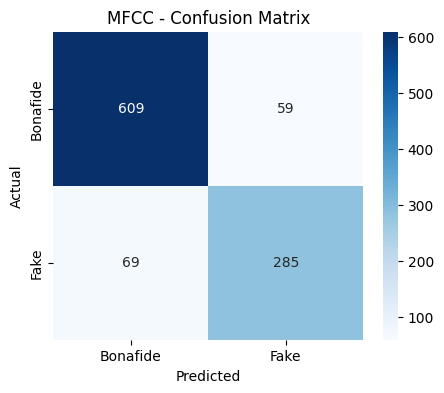

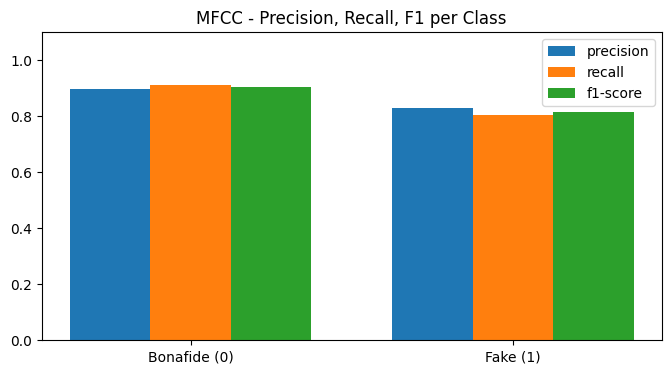

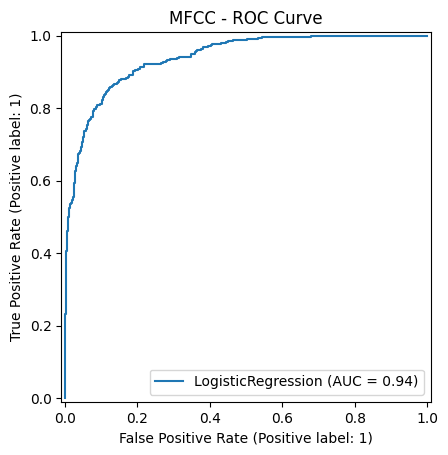

In [17]:
X_mfcc = extract_features(file_paths, 'mfcc')
train_and_evaluate_with_plots(X_mfcc, labels, 'mfcc')

Mel Spectrogram

Extracting MEL: 100%|██████████| 5108/5108 [01:55<00:00, 44.21it/s]



Training Logistic Regression on MEL Features

Accuracy: 0.9266
Confusion Matrix:
[[641  27]
 [ 48 306]]


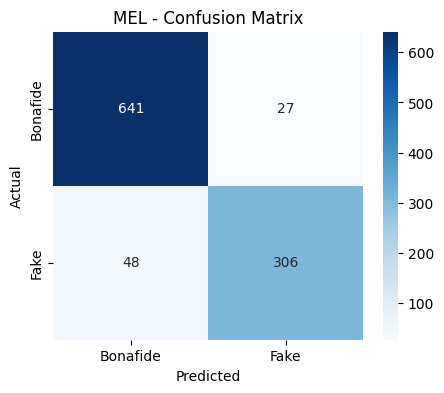

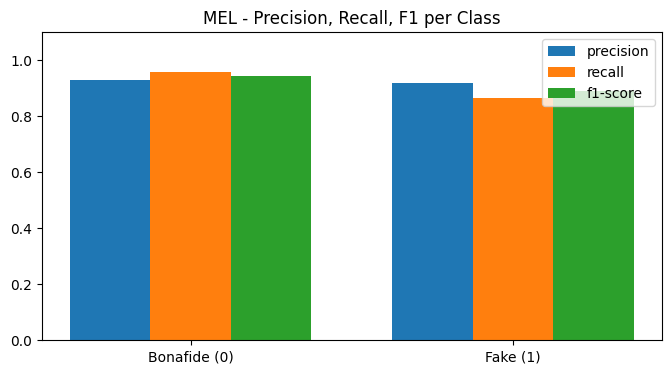

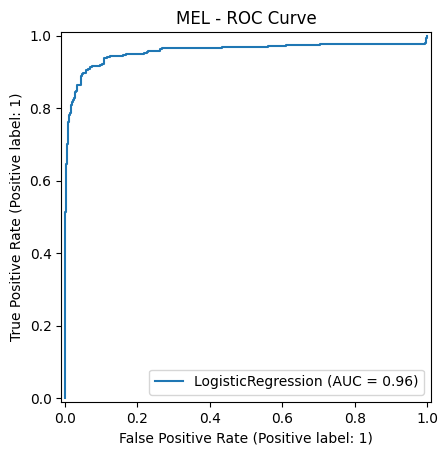

In [18]:
X_mel = extract_features(file_paths, 'mel')
train_and_evaluate_with_plots(X_mel, labels, 'mel')

Chroma

Extracting CHROMA:  74%|███████▍  | 3804/5108 [02:14<00:35, 36.79it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
Extracting CHROMA: 100%|██████████| 5108/5108 [03:16<00:00, 26.06it/s]



Training Logistic Regression on CHROMA Features

Accuracy: 0.8796
Confusion Matrix:
[[640  28]
 [ 95 259]]


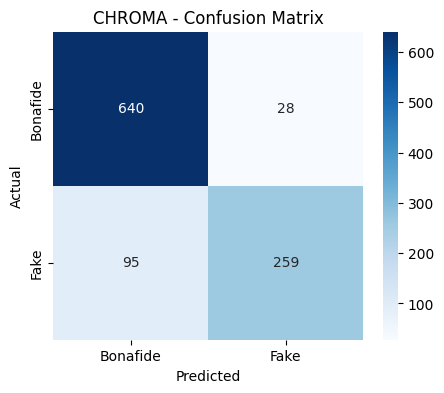

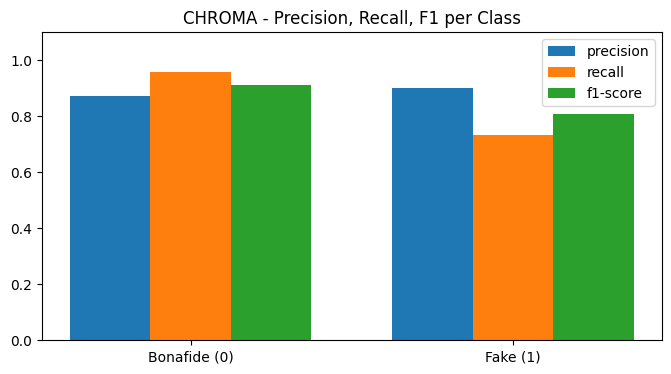

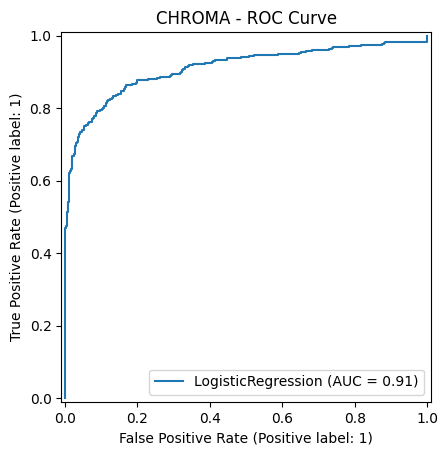

In [19]:
X_chroma = extract_features(file_paths, 'chroma')
train_and_evaluate_with_plots(X_chroma, labels, 'chroma')

#Final Evaluation Report
This report summarizes the performance of logistic regression models trained separately on three different audio feature sets extracted from the Urdu Deepfake Audio Dataset.

#1. MFCC (Mel Frequency Cepstral Coefficients)
Accuracy: 87.48%

Confusion Matrix:

lua
Copy
Edit
[[609  59]
 [ 69 285]]
Observations:

Strong overall performance

Fairly balanced detection of bonafide and fake samples

False positives: 59, False negatives: 69

#2. Mel Spectrogram
Accuracy: 92.66%

Confusion Matrix:

lua
Copy
Edit
[[641  27]
 [ 48 306]]
Observations:

Best performing feature set

High precision and recall for both classes

Significantly fewer errors compared to MFCC and Chroma

#3. Chroma Features
Accuracy: 87.96%

Confusion Matrix:

lua
Copy
Edit
[[640  28]
 [ 95 259]]
Observations:

Performs similar to MFCC

Strong bonafide detection

Relatively high false negatives for spoofed samples

#Conclusion
Mel Spectrogram features outperform MFCC and Chroma in terms of accuracy and balance.

MFCC and Chroma provide good baseline performance, but are less effective at detecting spoofed audio compared to Mel.

These results suggest that Mel spectrograms are the most discriminative feature set for this deepfake detection task using logistic regression.